In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
# from prophet import Prophet
from functions import load_data, replace_missing_long, widen_data, feature_engineering, normalize_data, remove_outliers, group_data, remove_incorrect_values, impute_missing_wide

In [10]:
data = load_data()
data = remove_incorrect_values(data)

### Task 1B: Data cleaning

In [11]:
data = replace_missing_long(data)

In [12]:
# transform the data to wide format
data = widen_data(data)

data

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17 12:04:42.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-17 18:28:25.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-18 09:29:51.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-19 14:43:30.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-19 17:29:10.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358917,AS14.33,2014-05-30 22:32:05.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358918,AS14.33,2014-05-30 22:32:11.049,NaN,3.122,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358919,AS14.33,2014-05-30 22:32:14.240,NaN,1.003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358920,AS14.33,2014-05-30 22:32:15.246,NaN,4.134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
activity,22965.0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
appCat.builtin,91285.0,19.446411,312.914956,0.001,2.02000,4.038000,9.922000,33960.246
appCat.communication,74276.0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
appCat.entertainment,27124.0,37.577866,262.965225,0.001,1.33400,3.391500,14.922250,32148.677
appCat.finance,939.0,21.755251,39.218361,0.131,4.07200,8.026000,20.155000,355.513
appCat.game,813.0,128.391615,327.145246,1.003,14.14800,43.168000,123.625000,5491.793
appCat.office,5642.0,22.578892,449.601382,0.003,2.00400,3.106000,8.043750,32708.818
appCat.other,7650.0,25.810839,112.781355,0.014,7.01900,10.028000,16.829250,3892.038
appCat.social,19145.0,72.401906,261.551846,0.094,9.03000,28.466000,75.372000,30000.906


/var/folders/_8/8ncqfw110mzcbtcgj00vq8740000gn/T/ipykernel_10204/1244199711.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


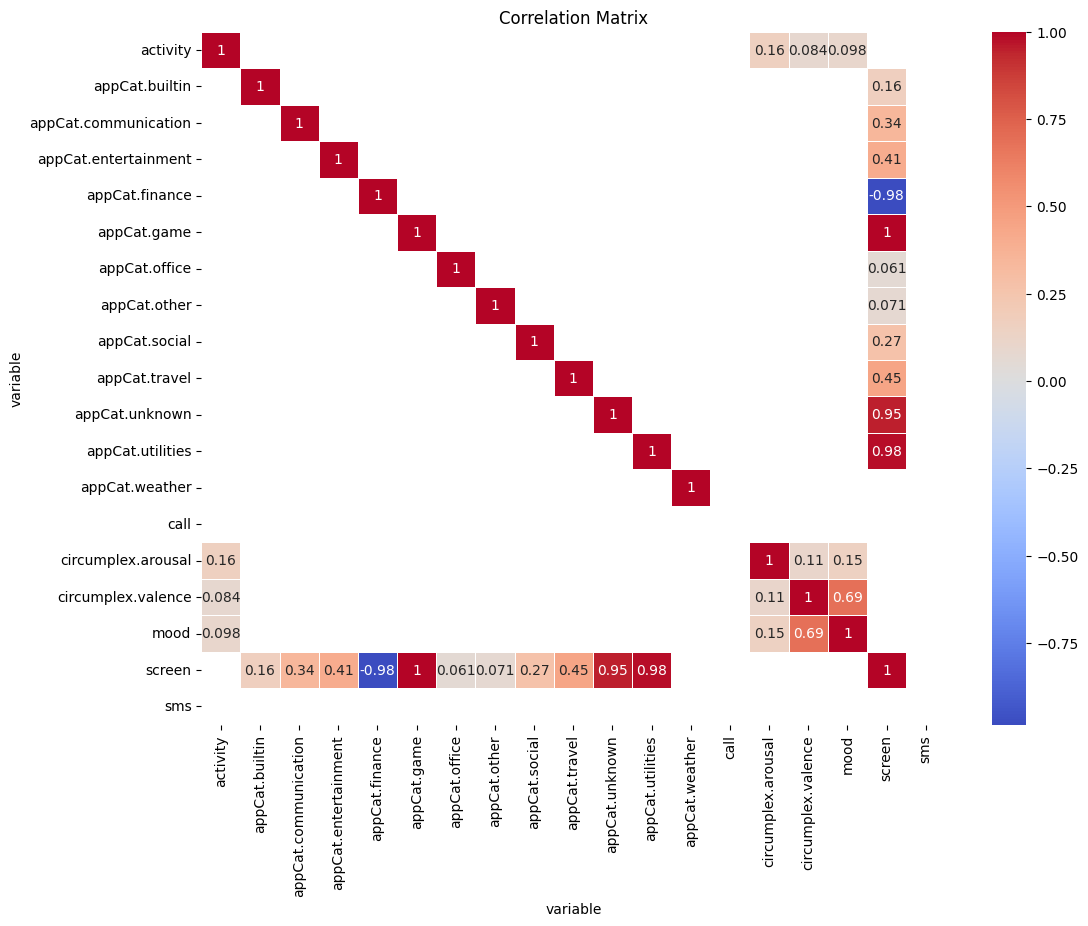

In [14]:
corr = data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [15]:
# sum variables
sum_vars = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 
                 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 
                 'appCat.weather', 'screen', 'call', 'sms']
# mean variables
mean_vars = ['circumplex.arousal', 'circumplex.valence', 'activity', 'mood']

# group the wide data by day and id and aggregate the sum and mean of the variables
grouped_wide = group_data(data)
grouped_wide

/Users/ryonamba/Documents/VU/VU-master_year_1/data_mining/assignment_1/DM1/functions.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  [pd.Grouper(key='time', freq='D')]).mean().reset_index()


variable,time,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,call,sms,circumplex.arousal,circumplex.valence,activity,mood
0,2014-02-17,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.718116,0.281884,NaN,NaN,NaN,NaN
1,2014-02-18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.836546,0.163454,NaN,NaN,NaN,NaN
2,2014-02-19,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.749003,0.250997,NaN,NaN,NaN,NaN
3,2014-02-20,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.764286,0.235714,NaN,NaN,NaN,NaN
4,2014-02-21,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.709028,0.290972,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2014-06-05,6.454897,3.538085,0.0,0.0,0.0,0.0,0.174760,0.634554,0.832978,0.0,0.000000,0.0,8.751251,0.040590,0.000000,-0.017316,0.949057,0.152343,7.0
109,2014-06-06,3.261717,5.899738,0.0,0.0,0.0,0.0,0.125566,0.000000,0.000000,0.0,0.007145,0.0,9.425283,0.055172,0.000000,0.500000,0.808962,0.189476,7.5
110,2014-06-07,36.169050,5.294712,0.0,0.0,0.0,0.0,0.044705,0.768705,0.000000,0.0,0.000000,0.0,39.786892,0.000000,0.014388,-1.000000,0.745283,0.081893,8.0
111,2014-06-08,10.648152,11.379242,0.0,0.0,0.0,0.0,0.547545,5.780606,0.000000,0.0,0.000000,0.0,34.278727,0.000000,0.000000,-1.500000,1.000000,0.079510,6.5


In [16]:
# show rows where mood is nan
grouped_wide[grouped_wide['mood'].isna()]


variable,time,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,call,sms,circumplex.arousal,circumplex.valence,activity,mood
0,2014-02-17,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.718116,0.281884,NaN,NaN,NaN,NaN
1,2014-02-18,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.836546,0.163454,NaN,NaN,NaN,NaN
2,2014-02-19,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.749003,0.250997,NaN,NaN,NaN,NaN
3,2014-02-20,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.764286,0.235714,NaN,NaN,NaN,NaN
4,2014-02-21,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709028,0.290972,NaN,NaN,NaN,NaN
5,2014-02-22,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.565206,0.434794,NaN,NaN,NaN,NaN
6,2014-02-23,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592187,0.407813,NaN,NaN,NaN,NaN
7,2014-02-24,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.762103,0.237897,NaN,NaN,NaN,NaN
8,2014-02-25,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.702441,0.297559,NaN,NaN,NaN,NaN
11,2014-02-28,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734662,0.265338,NaN,NaN,NaN,NaN


In [17]:
# remove first 14 days and last day -> no information there, only call and SMS
grouped_wide = grouped_wide[15:-1]
grouped_wide

variable,time,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,call,sms,circumplex.arousal,circumplex.valence,activity,mood
15,2014-03-04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.776831,0.209563,0.500000,1.455752,NaN,7.000000
16,2014-03-05,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.704381,0.219429,0.333333,0.833333,NaN,7.166667
17,2014-03-06,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.797395,0.151282,-0.050000,0.675000,NaN,7.225000
18,2014-03-07,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.709058,0.220290,0.675000,1.100000,NaN,7.450000
19,2014-03-08,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.620175,0.274561,0.200000,0.900000,NaN,7.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2014-06-04,2.887951,18.274684,0.0,0.0,0.0,0.0,0.158910,0.282533,0.000000,0.0,0.000000,0.0,21.409270,0.004098,0.004098,0.500000,1.000000,0.046385,7.000000
108,2014-06-05,6.454897,3.538085,0.0,0.0,0.0,0.0,0.174760,0.634554,0.832978,0.0,0.000000,0.0,8.751251,0.040590,0.000000,-0.017316,0.949057,0.152343,7.000000
109,2014-06-06,3.261717,5.899738,0.0,0.0,0.0,0.0,0.125566,0.000000,0.000000,0.0,0.007145,0.0,9.425283,0.055172,0.000000,0.500000,0.808962,0.189476,7.500000
110,2014-06-07,36.169050,5.294712,0.0,0.0,0.0,0.0,0.044705,0.768705,0.000000,0.0,0.000000,0.0,39.786892,0.000000,0.014388,-1.000000,0.745283,0.081893,8.000000


In [18]:
# rows where there are still missing values 
grouped_wide[grouped_wide.isna().any(axis=1)]

variable,time,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,call,sms,circumplex.arousal,circumplex.valence,activity,mood
15,2014-03-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.776831,0.209563,0.500000,1.455752,NaN,7.000000
16,2014-03-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.704381,0.219429,0.333333,0.833333,NaN,7.166667
17,2014-03-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.797395,0.151282,-0.050000,0.675000,NaN,7.225000
18,2014-03-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709058,0.220290,0.675000,1.100000,NaN,7.450000
19,2014-03-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.620175,0.274561,0.200000,0.900000,NaN,7.300000
20,2014-03-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.577778,0.322222,-0.100000,1.100000,NaN,7.200000
21,2014-03-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.729798,0.199495,-0.166667,0.633333,NaN,7.066667
22,2014-03-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819608,0.084804,0.200000,0.400000,NaN,6.400000
23,2014-03-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.790763,0.103974,0.400000,0.600000,NaN,6.700000
24,2014-03-13,0.282482,1.046222,0.073508,0.000000,0.000000,0.000000,0.638429,0.338806,0.000000,0.000000,0.010707,0.000000,2.262041,0.640315,0.194433,-0.437500,0.962500,NaN,7.212500


In [19]:

# Round 2 - imputation of missing values 
# imputation with backfill 
grouped_wide['activity'] = grouped_wide['activity'].bfill()
# grouped_wide.head(20)
grouped_wide[['circumplex.arousal','circumplex.valence', 'mood']] = grouped_wide[['circumplex.arousal','circumplex.valence', 'mood']].interpolate(method='linear')

# grouped_wide[grouped_wide.isna().any(axis=1)]

/var/folders/_8/8ncqfw110mzcbtcgj00vq8740000gn/T/ipykernel_10204/1423205502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_wide['activity'] = grouped_wide['activity'].bfill()
/var/folders/_8/8ncqfw110mzcbtcgj00vq8740000gn/T/ipykernel_10204/1423205502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_wide[['circumplex.arousal','circumplex.valence', 'mood']] = grouped_wide[['circumplex.arousal','circumplex.valence', 'mood']].interpolate(method='linear')


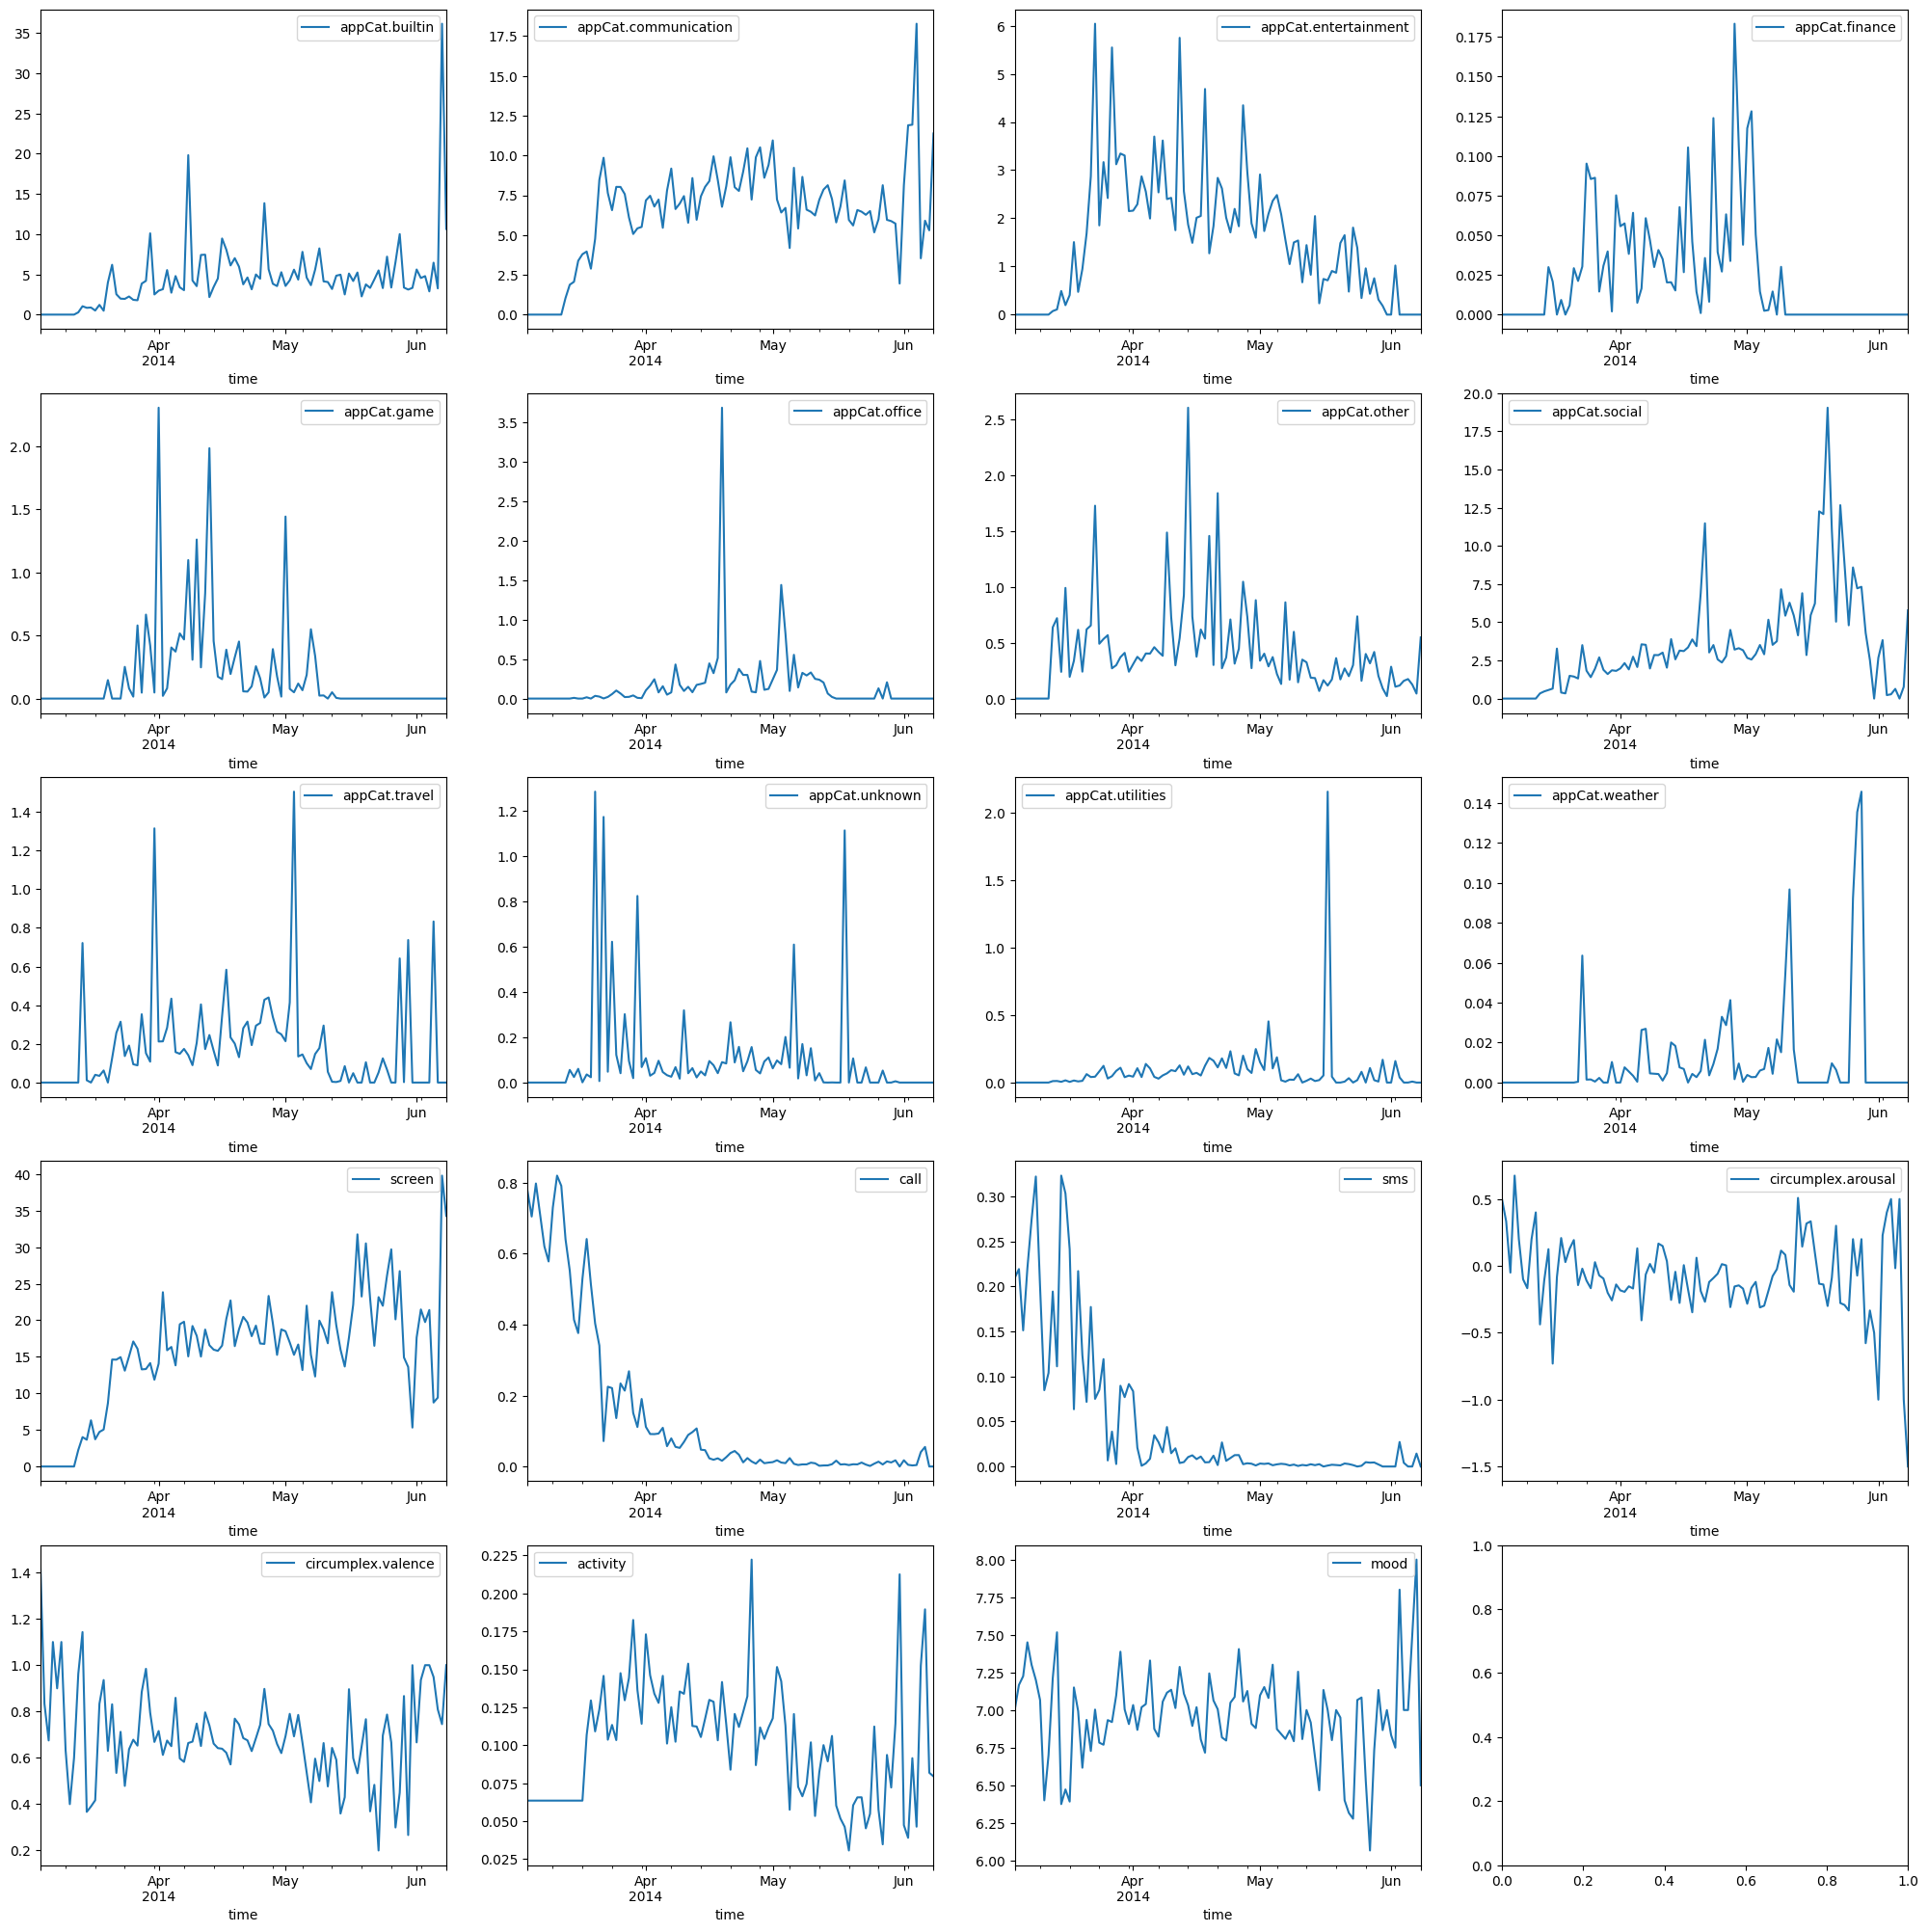

In [20]:
# plot of vars after all imputation steps - line plot 
p_id = list(itertools.product(list(range(0,5)), list(range(0,4))))
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(25,25))

for i, col in enumerate(grouped_wide.columns[1:]):
    grouped_wide.plot(x='time', y=col, kind='line', ax=axs[p_id[i][0],p_id[i][1]])
plt.show()

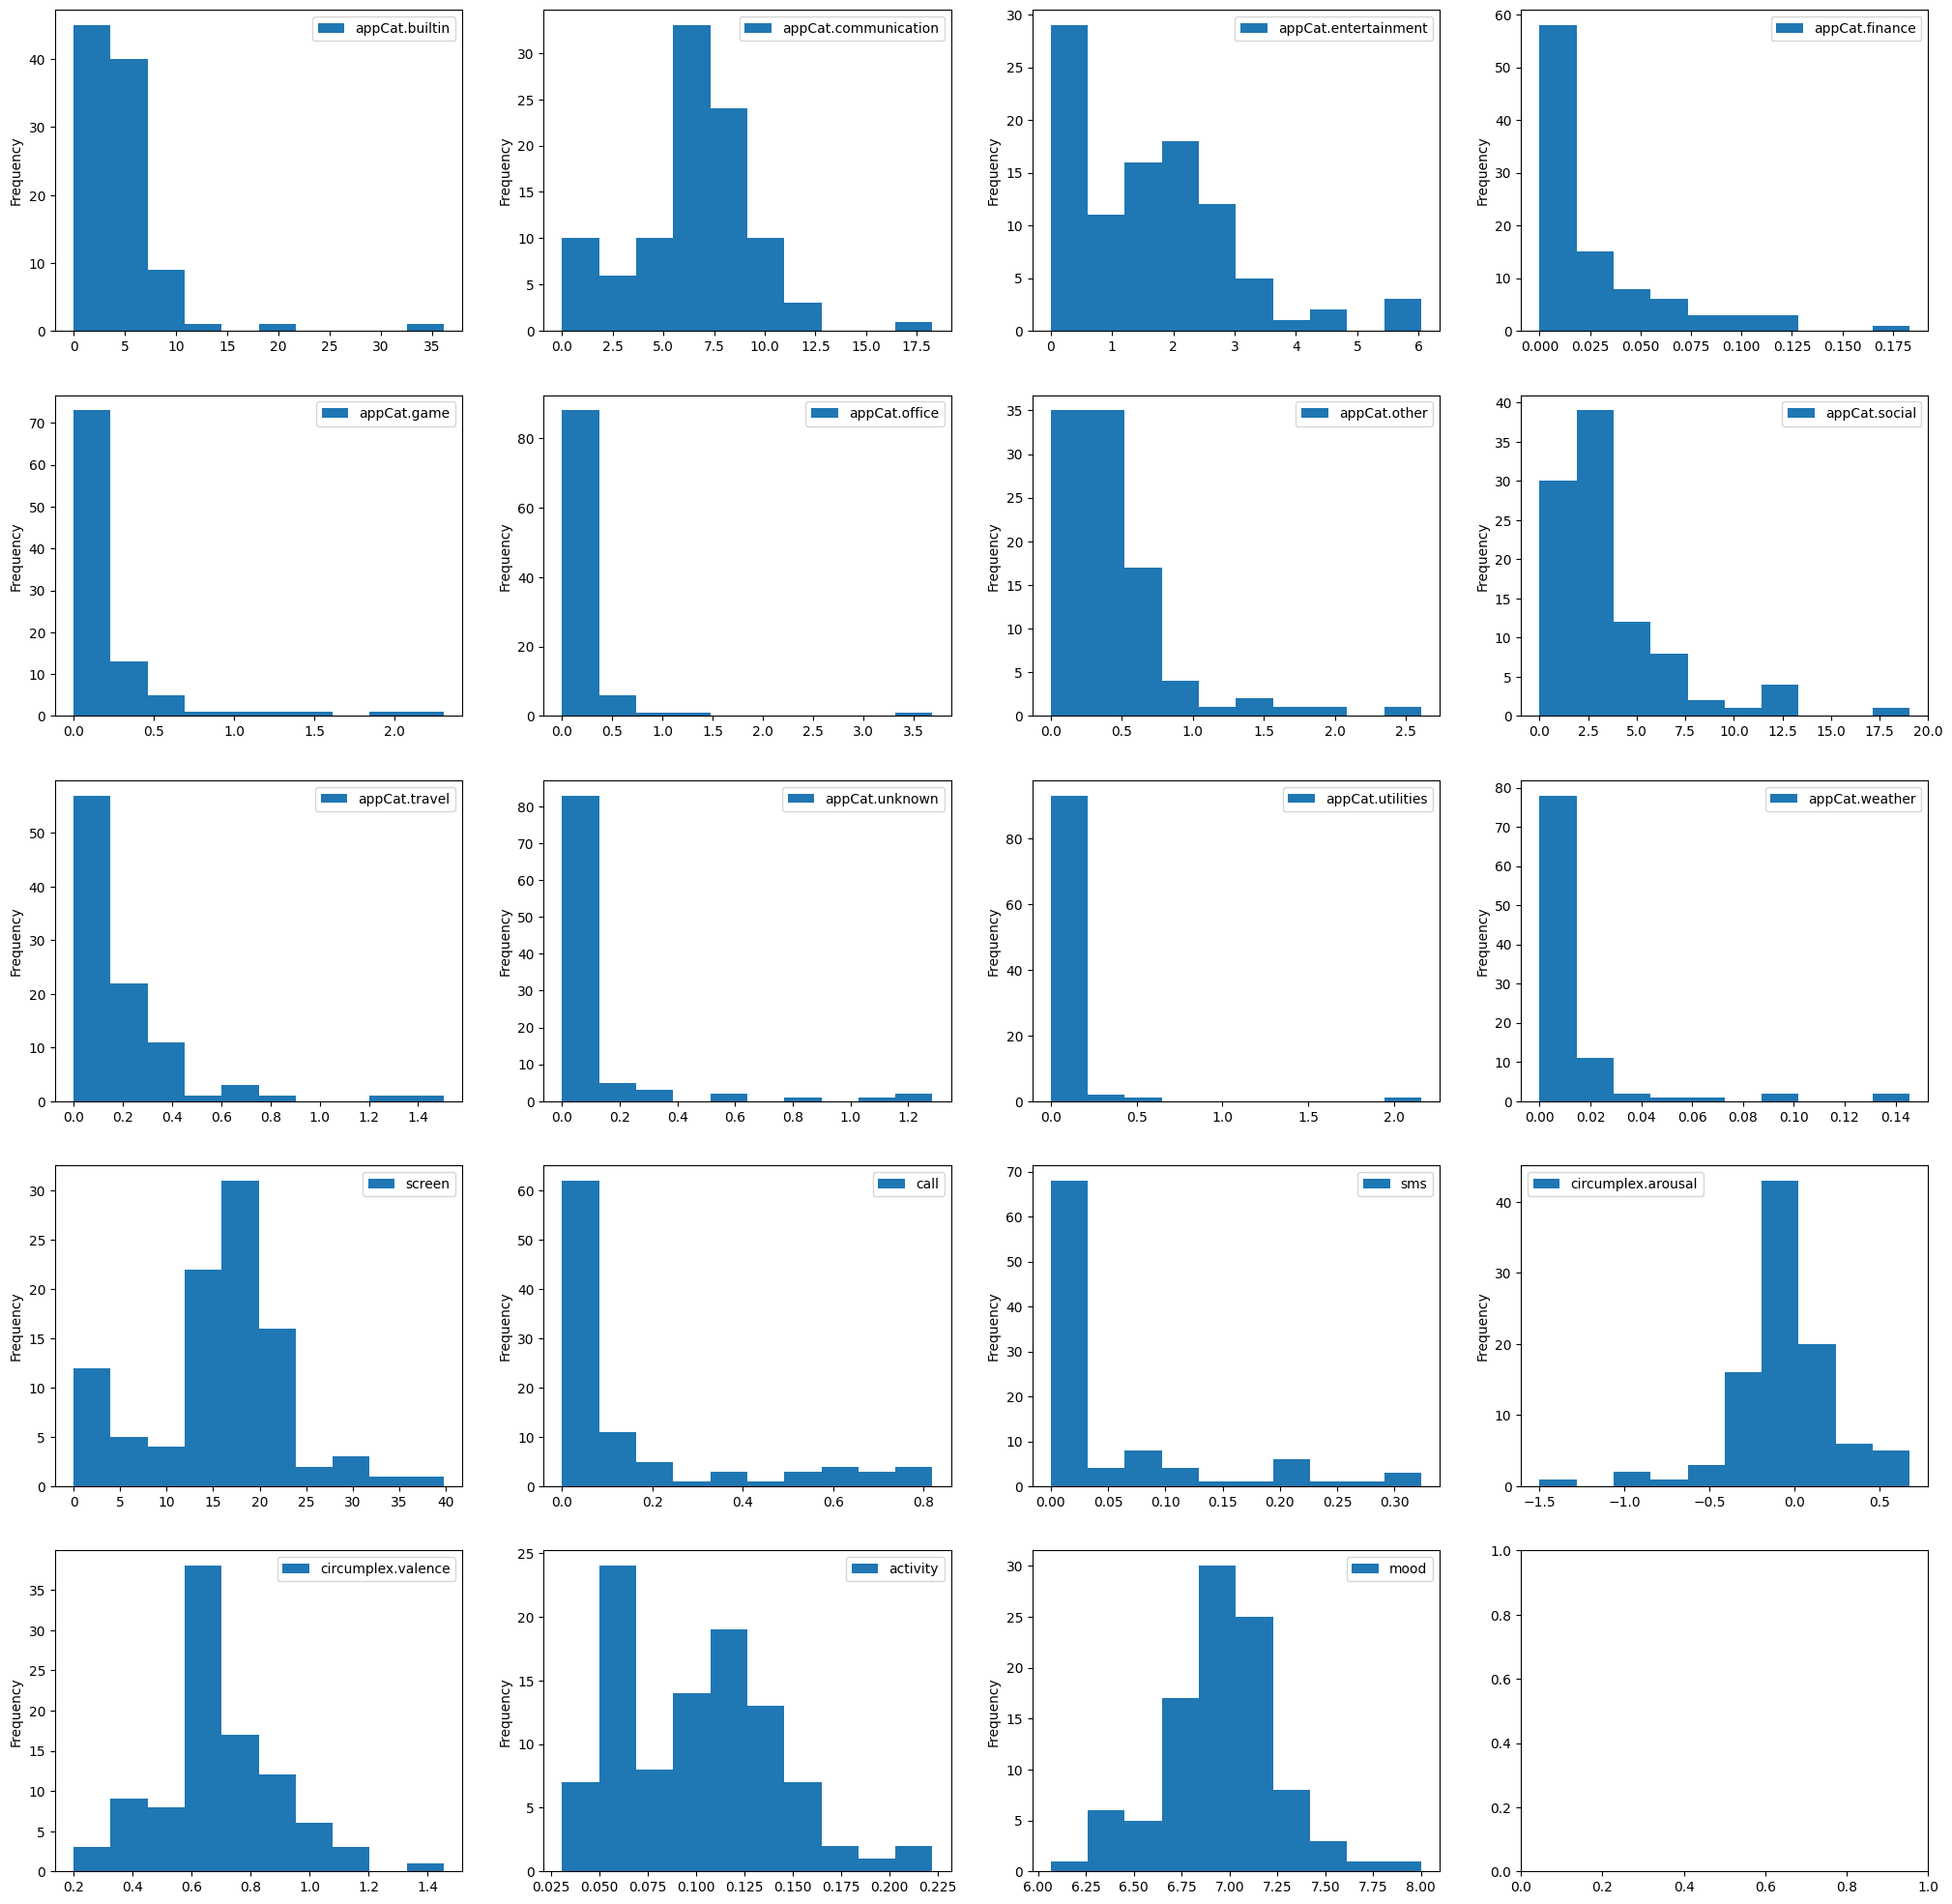

In [21]:
# plot of vars after all imputation steps - histogram 
p_id = list(itertools.product(list(range(0,5)), list(range(0,4))))
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(25,25))

for i, col in enumerate(grouped_wide.columns[1:]):
    grouped_wide.plot(x='time', y=col, kind='hist', ax=axs[p_id[i][0],p_id[i][1]])
plt.show()

In [22]:
# show rows with missing values
grouped_wide[grouped_wide.isnull().any(axis=1)]

variable,time,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,call,sms,circumplex.arousal,circumplex.valence,activity,mood


/var/folders/_8/8ncqfw110mzcbtcgj00vq8740000gn/T/ipykernel_10204/3002004853.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = grouped_wide.corr()


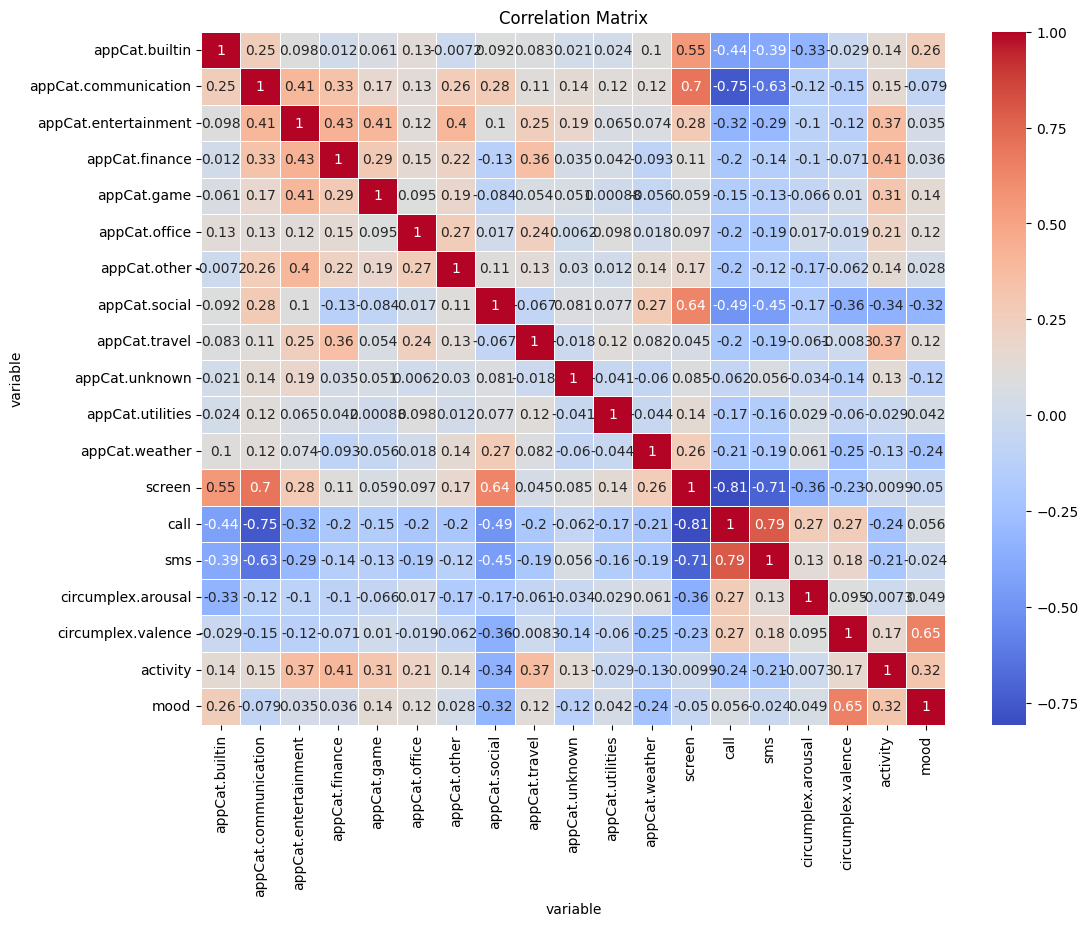

In [23]:
# correlation matrix of the aggregated variables
corr = grouped_wide.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [24]:
from itertools import cycle

palette = sns.color_palette("husl", n_colors=len(data.id.unique()))
color_cycle = cycle(palette)

for i in data.id.unique():
    current_color = next(color_cycle)
    plt.figure(figsize=(12, 6)) 
    sns.lineplot(
        data=data[data.id == i], 
        x='time', 
        y='mood', 
        color=current_color, 
        marker='o',  # Show data points as dots
        linestyle='--'  # Make the lines dashed
    )
    plt.title(i)
    plt.savefig('plots/timeseries/' + i + '.png')
    plt.clf()

/var/folders/_8/8ncqfw110mzcbtcgj00vq8740000gn/T/ipykernel_10204/522674978.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [25]:
# for every variable, plot the distribution
vars = ['mood']
for var in vars:
    if var not in ['id', 'time']:
        sns.histplot(data, x=var, kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        # save plot
        plt.savefig('plots/distribution/' + var + '.png')
        plt.clf()

<Figure size 640x480 with 0 Axes>

## TASK 1C: FEATURE ENGINEERING

## Modelling

In [26]:
# select random id as data
df_prophet = data[data.id == 'AS14.01']

# Prepare the data
data['time'] = pd.to_datetime(data['time'])
df_prophet = df_prophet.rename(columns={'time': 'ds', 'mood': 'y'})

# Initialize the model
model = Prophet()

# Fit the model on the dataset
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=10)  # predict the next 'periods' days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

NameError: name 'Prophet' is not defined